# LAB 7: Rejection Sampling, Metropolis-Hastings
### Density Functions and Plots
### AI and Machine Learning // Suchkova Natalia М8О-114М-22
09.01.2023 @ MAI IT-Center

<a id='op0'></a>
### The Task
1. Реализовать Rejection Sampling
2. Реализовать алгоритм Метрополиса-Гастингса  - цепь Маркова Монте Карло (MCMC)
3. Применить для 2 тестовых функций плотности и построить график сэмплирования точки и линий уровня

## Table of Contents

1. [**Создание функций**](#op1)
    - [Базовая вспомогательная функция (Гауссиан)](#op11)
    
    - [Функция 1. Распределение Пуассона](#op12)
    
    - [Фукнция 2. Распределение Лапласа](#op13)
    
    
2. [**Rejection Sampling**](#op2)
    
    
3. [**Алгоритм Метрополиса-Гастингса**](#op3)


In [2]:
import numpy as np
import random
import math

from typing import Tuple, Mapping

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

In [3]:
rand = np.random.RandomState(seed=11)

<a id='op1'></a>
<a id='op11'></a>

#### Базовая функция для сэмплирования - функция нормального распределения
$$ g(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} * e^{-\frac{1}{2}\big(\frac{x-\mu}{\sigma}\big)^2}$$

In [4]:
normal_distr = lambda x: np.e ** (-0.5 * ((x - np.mean(x)) / np.std(x)) ** 2) / (2 * np.pi * np.std(x) ** 2) ** 0.5 

<a id='op12'></a>

#### Функция распределения Пуассона
$$P(X = r) = \frac{e^{-\lambda}\lambda^r}{r!}$$

In [5]:
def Poisson(r, lmbd=7.4):
    '''
    Func:
        Распределение Пуассона
    
    Args:
        r - different values of random variable X
        lmbd - the mean number of occurrences, r represents 
    
    Return:
        Возвращает случайное число, соответствующее распределению.
    '''
    return ((math.e ** (-lmbd) * lmbd ** r))/ math.factorial(r)

In [6]:
Poisson(1)

0.004523270432358837

In [7]:
x = np.arange(1, 101)
data_pois = [Poisson(dot) for dot in x.tolist()]

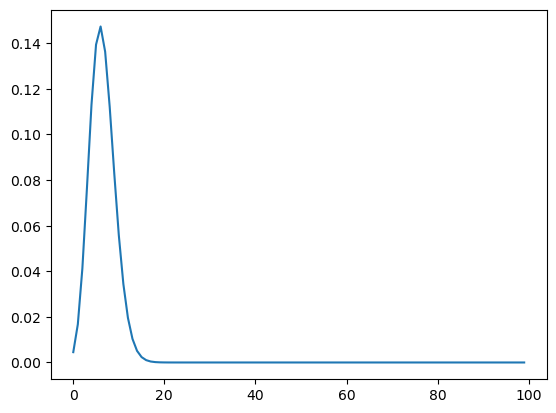

In [8]:
plt.plot(data_pois)
plt.show()

<a id='op13'></a>

#### Функция распределения Лапласа
$$f(x | \mu, b) = \frac{1}{2b} \exp^{ -\frac{|x - \mu|}{b}}$$

In [9]:
def Laplace(x, m: float = 0.4, d: float = 0.):
    '''
    Func:
        Распределение Лапласа.
    
    Args:
        m - мат. ожидание.
        d - дисперсия.
    
    Return:
        Возвращает случайное число, соответствующее распределению.
    '''
    return (1 / 2 * m) * math.e ** (abs(x - d) / -m)

In [10]:
x = np.linspace(-5, 5, 1000)
data_lapl = [Laplace(dot, 0.8, 2) for dot in x.tolist()]

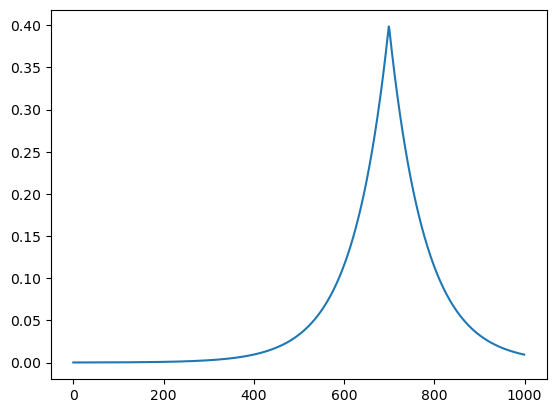

In [11]:
plt.plot(data_lapl)
plt.show()

#### Функция посложнее

In [38]:
def smth(x):
    if x == 0:
        val = 1
    else:
        val = math.sin(x ** 2) / x ** 2
    return val + 0.25

In [39]:
x = np.linspace(-6, 6, 1000)
d_smth = [smth(dot) for dot in x.tolist()]

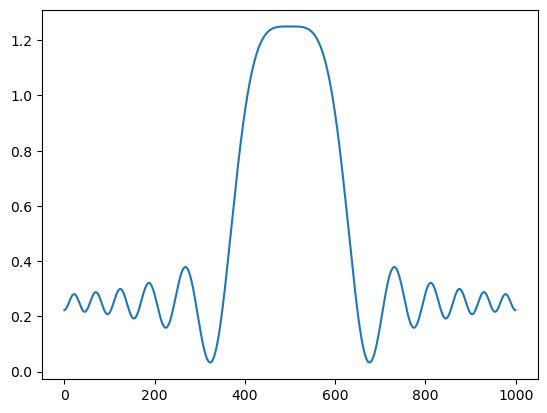

In [40]:
plt.plot(d_smth)
plt.show()

In [12]:
# def something(x):
#     if x >= 0:
#         if 4 < x < 5:
#             val = -(0.08 * (x - 4) * (x - 5) * (-x**2 + 3) * np.sqrt(x))
#         else:
#             val = 0.08 * (x - 4) * (x - 5) * (-x**2 + 3) * np.sqrt(x)
#     else:
#         if -5 < x < -4:
#             val = -(0.08 * (x + 4) * (x + 5) * (x**2 - 3) * np.sqrt(-x))
#         else:
#             val = 0.08 * (x + 4) * (x + 5) * (x**2 - 3) * np.sqrt(-x)
        
#     return val

In [13]:
# x = np.linspace(-6, 6, 1000)
# data_smth = [something(dot) for dot in x.tolist()]

<a id='op2'></a>
## Rejection Sampling

**Rejection Sampling** это средство генерации случайных чисел, принадлежащих определенному распределению.

Чаще всего применяется для семплирования сложных вероятностных распределений, в котором генерация семплов по $f(x)$ происходит с помощью более простого вспомогательного распределения $g(x)$, которое уже известно, как семплировать, и которое удовлетворяет следующему условию: $$\forall x \to f(x) < cg(x) $$
$c > 1$ - константа вероятностного распределения.

Примерная логика работы алгоритма:

1. Взять семпл $x$ по базовому $g(x)$ распределению 

2. Выбрать случайное число n из отрезка $[0; cg(x)]$ 

3. Вычислить $f(x)$

    - Если $n \leq f(x)$, то $x$ добавляется к семплам

    - Если $n > f(x)$, то $x$ отклоняется


4. Алгоритм выбирает точки $[x, n]$ из области под графиком $f(x)$, так происходит сэмплирование.

5. Алгоритм эффективен, когда форма вспомогательной функции $g()$ близка к форме целевой функции $f(x)$.


Хорош, когда размерность выборки невысока и можем подобрать константу с.

- https://cosmiccoding.com.au/tutorials/rejection_sampling

In [18]:
def rej_sampl(data: np.array, target_func: Mapping, base_func: Mapping,
              size: int = 1000, c: float = 1.) -> Tuple:
    true_x=[]
    true_y=[]
    false_x=[]
    false_y=[]
    
    # задаем границы
    y_min = min([target_func(dot) for dot in data.tolist()])
    
    x = rand.uniform(data.min(), data.max(), size=size)
    y = rand.uniform(y_min, c * base_func(x), size=size)
    
    for i in range(len(x)): 
        if target_func == Poisson:
            val = int(x[i])
        else:
            val = x[i]
        if y[i] <= target_func(val):
            true_x.append(x[i])
            true_y.append(y[i])
        else:
            false_x.append(x[i])
            false_y.append(y[i])
            
    return x, y, true_x, true_y, false_x, false_y

In [19]:
x = np.linspace(-10, 10, 1000)
rsl = rej_sampl(x, Laplace, normal_distr, c=2.8, size=4000)

In [21]:
print(len(rsl[0]), len(rsl[1]), len(rsl[2]), len(rsl[3]), len(rsl[4]), len(rsl[5]))

4000 4000 139 139 3861 3861


In [81]:
x = np.arange(1, 101)
rsp = rej_sampl(x, Poisson, normal_distr, c=34, size=2000)

In [47]:
x = np.linspace(-6, 6, 1000)
rs_smth2 = rej_sampl(x, smth, normal_distr, c=11, size=4000)

In [25]:
def plot_RS(x, func: Mapping, title: str, true_x, true_y, false_x, false_y, show_density=False):
    
    y = [func(i) for i in x]

    fig, ax = plt.subplots(figsize=(16,8))
    if show_density:
        plt.hist(rs[2], 15, density=True, color='lightblue', alpha=0.4)
    plt.plot(x, y, color='blue', alpha=0.8)
    plt.scatter(true_x, true_y, s=2, color='magenta')
    plt.scatter(false_x, false_y, s=1, color='mediumturquoise')


    ax.set_title(f'Rejection Sampling of {title} Function', fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

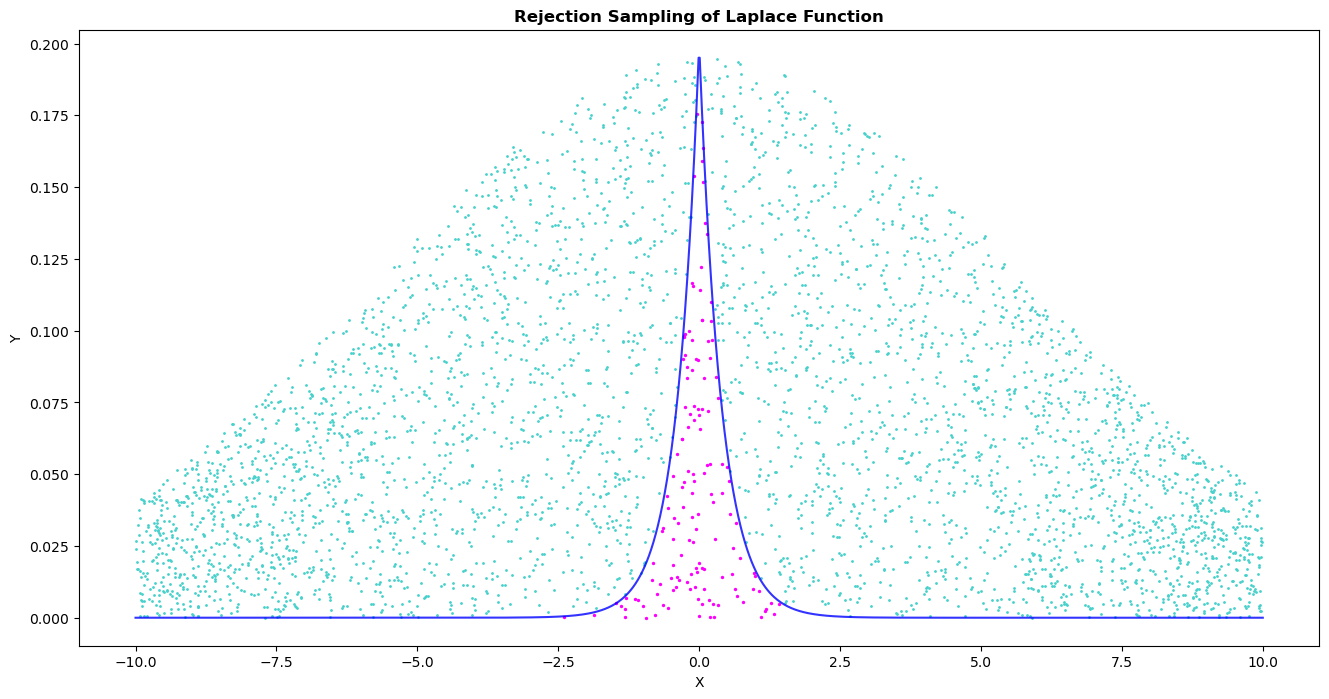

In [26]:
x = np.linspace(-10, 10, 1000)
plot_RS(x, Laplace, 'Laplace', rsl[2], rsl[3], rsl[4], rsl[5])

In [27]:
print(f"Эффективность алгоритма: {len(rsl[2])/(len(rsl[4]) + len(rsl[2])) * 100:0.1f} %")

Эффективность алгоритма: 3.5 %


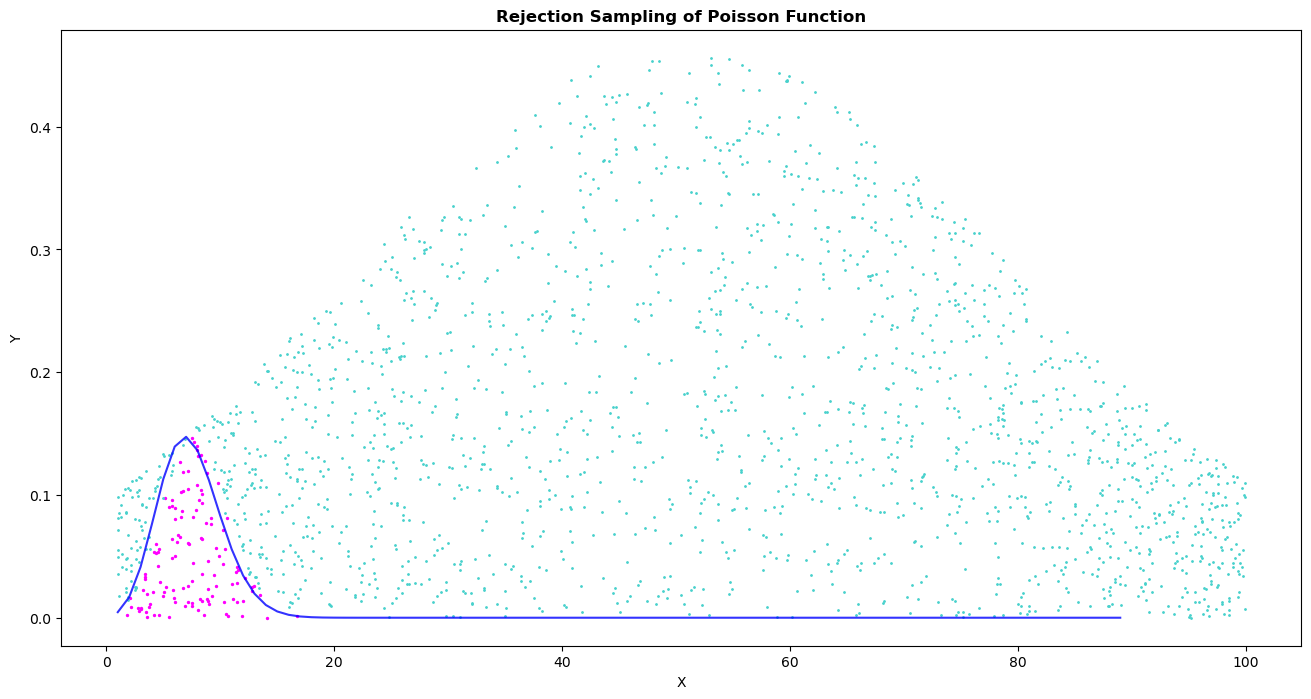

In [82]:
x = np.arange(1, 90)
plot_RS(x, Poisson, 'Poisson', rsp[2], rsp[3], rsp[4], rsp[5])

In [83]:
print(f"Эффективность алгоритма: {len(rsp[2])/(len(rsp[4]) + len(rsp[2])) * 100:0.1f} %")

Эффективность алгоритма: 6.1 %


Низкие эффективности получены ввиду различия форм базовой и заданных для сэмплирования функций.

График слегка сбивается от выделенных точек, так как в распределении пуассона есть факториал, под которым могут быть только целые числа, поэтому при режекшон сэмплинге пришлось поставить условие  
`if target_func == Poisson:`

`    val = int(x[i])`

`else:`

`    val = x[i]`

поэтому некоторые округления сдвигают распределение точек по спискам с подходящими и неподходящими.

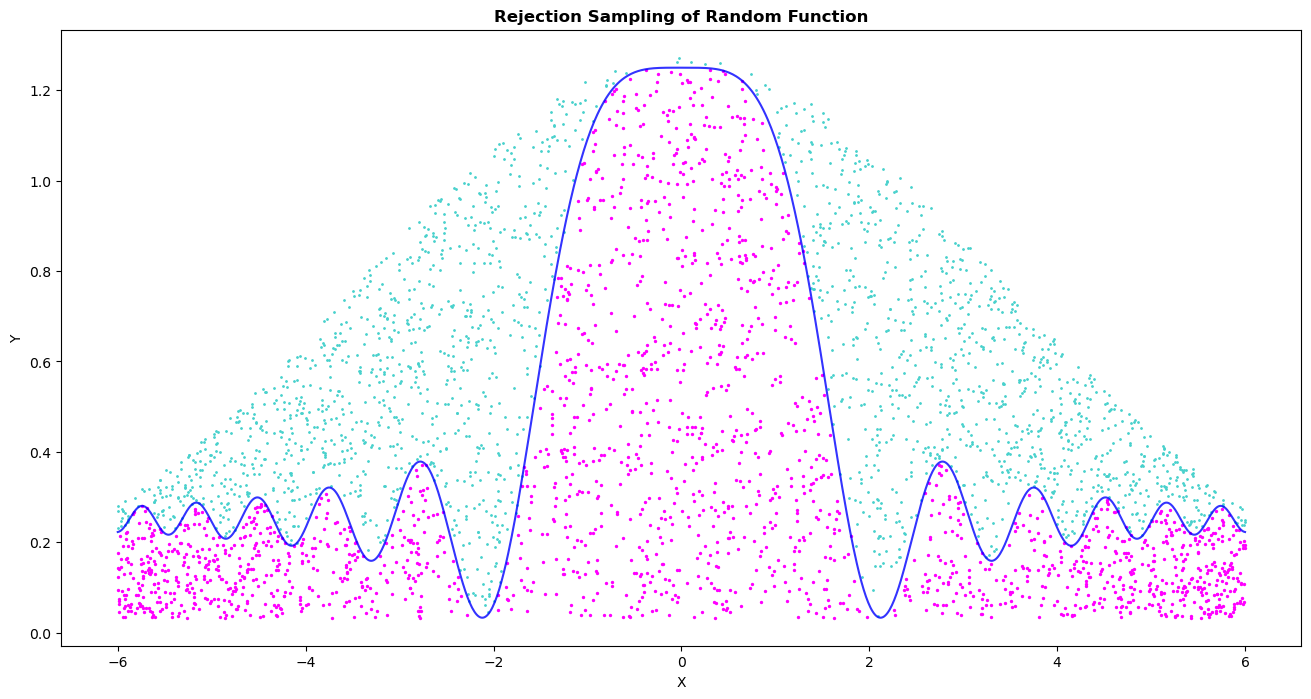

In [70]:
x = np.linspace(-6, 6, 1000)
plot_RS(x, smth, 'Random', rs_smth2[2], rs_smth2[3], rs_smth2[4], rs_smth2[5])

In [72]:
print(f"Эффективность алгоритма: {len(rs_smth2[2])/(len(rs_smth2[4]) + len(rs_smth2[2])) * 100:0.1f} %")

Эффективность алгоритма: 49.6 %


In [71]:
# x = np.linspace(-6, 6, 1000)
# plot_RS(x, something, 'Random', rs_smth[2], rs_smth[3], rs_smth[4], rs_smth[5])

<a id='op3'></a>
## MCMC

**Алгоритм Метрополиса-Гастингса** или *цепь Маркова Монте-Карло*, также применяется для сэмплирования. Однако этот метод позволяет сэмплировать любую функцию.

Основан на создании цепи Маркова: на каждом шаге алгоритма новое выбранное значение $x^{t+1}$зависит от предыдущего $x^t$. Он использует вспомогательную функцию $Q(x'|x^t)$, зависящую от $x^t$, для которой легко генерируется выборка. На каждом шаге для этой функции генерируется случайное значение $x'$, а затем с вероятностью $v$, (или с вероятностью 1, если $v > 1$), выбранное значение принимается как новое, иначе оставляется старое.
$$v = \frac{P(x')Q(x^t|x')}{P(x^t)Q(x'|x^t)}$$

Таким образом, алгоритм действует изнутри целевой функции путём построения случайного блуждания под её графиком, переходя от одной точки к другой, и время от времени забирая текущую точку блуждания в качестве сэмпла.

Алгоритм:
- Сгенерировать новое значение p случайным образом между 0 и 1, называем его p' (или p_new).
- Вычислить коэффициент acceptance ratio.
- Сгенерировать другое однородное случайное число от 0 до 1, v.
- Если v < R, принимаем новое значение и заменяем p = p'. В противном случае оставляем текущее значение p.
- Записываем конечное значение p.

In [51]:
def MCMC_sampl(data, target_func: Mapping, 
               base_func: Mapping, size: int = 1000, 
               max_dist: float = .5):
    '''
    Func:
        Реализация Metropolis Hastings
    Args:
        data (np.array): начальный сэт данных
        target_func (Mapping): целевая функция
        base_func (Mapping): вспомогательная функция
        size (int): размер сэмпл выборки
        max_dist (float, optional): maximum distance between previous and next values
        
    N - количество точек (int)
    f - функция
    x0 - начальная точка
    Return:
        np.array: накопленная плотность на координату
    '''
    x_prev = rand.uniform(data.min(), data.max())
    samples = [x_prev]
    
    for i in range(size):
        x_next = rand.normal(x_prev, max_dist)
         
        if target_func == Poisson:
            val_next = int(x_next)
            val_prev = int(x_prev)
        else:
            val_next = x_next
            val_prev = x_prev
            
        p_x_next = np.prod(target_func(val_next)) # вычисляет произведение элементов массива
        p_x_prev = np.prod(target_func(val_prev))
        
        q_x_prev_x_next = base_func(np.array(sorted([x_prev, x_next])))[0]
        q_x_next_x_prev = base_func(np.array(sorted([x_next, x_prev])))[0]
        
        p_q_divider = p_x_next * q_x_prev_x_next
        p_q_denominator = p_x_prev * q_x_next_x_prev
        
        acceptance_ratio = p_q_divider / p_q_denominator
                
        if rand.rand() < acceptance_ratio:
            x_prev = x_next
        
        samples.append(x_prev)
        
    return np.array(samples)

In [52]:
def plot_MCMC(x, func: Mapping, title: str, result_samples):
    if func == Poisson or smth:
        y = [func(i) for i in x]
        bins = 50
    else:
        y = func(x)
        bins = 30
    
    fig, ax = plt.subplots(figsize=(16,6))
    ax.hist(result_samples, bins, density=True, color='magenta', alpha=0.2)
    ax.plot(x, y, color='blue')

    ax.set_title(f'Markov Chain Monte Carlo Sampling of {title} Function', fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

    plt.show()

In [53]:
x = np.linspace(-5, 5, 1000)
mhl = MCMC_sampl(x, Laplace, normal_distr)

In [54]:
mhl

array([ 4.71499182,  5.04203231,  4.94771152, ..., -0.34741568,
       -0.05605706, -0.05605706])

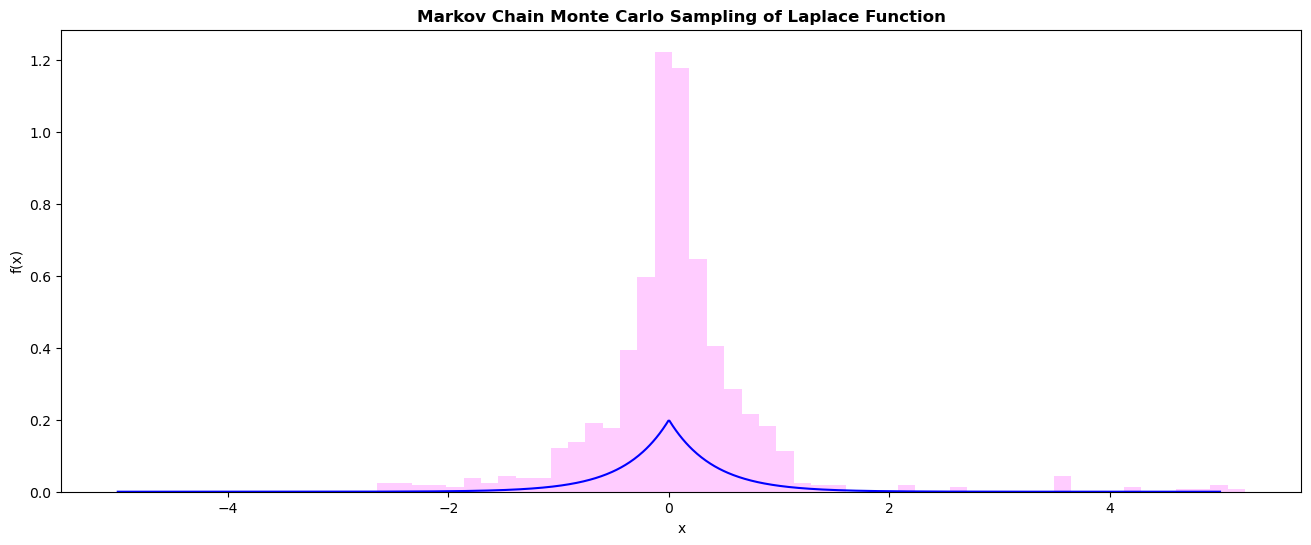

In [55]:
plot_MCMC(x, Laplace, 'Laplace', mhl)

In [62]:
x = np.arange(1, 51)
mhp = MCMC_sampl(x, Poisson, normal_distr)

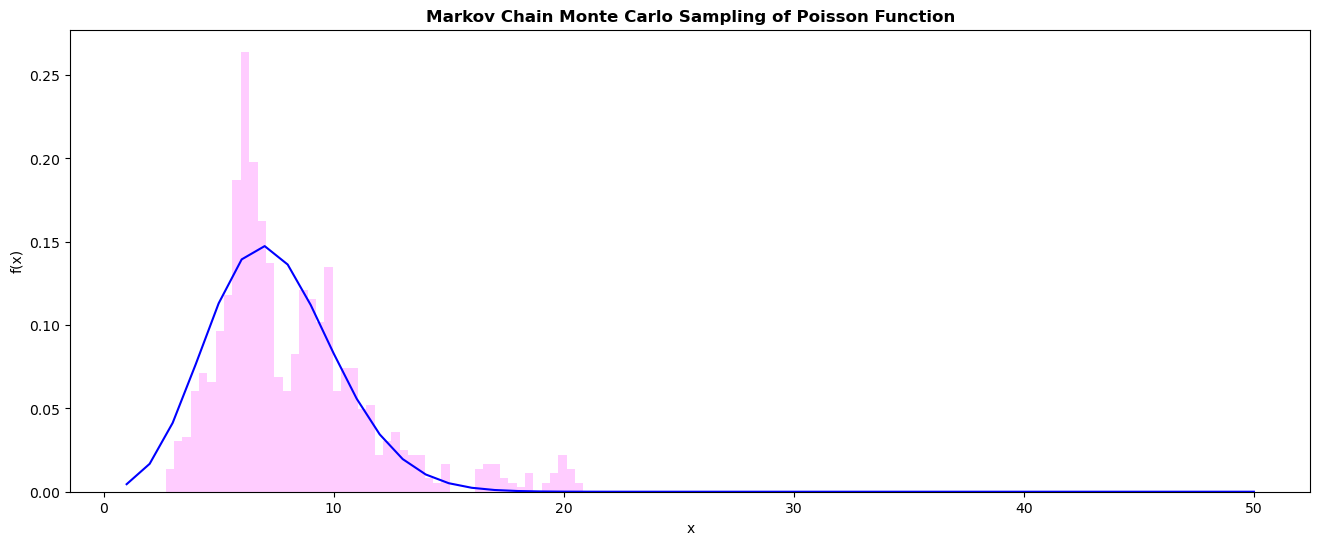

In [63]:
plot_MCMC(x, Poisson, 'Poisson', mhp)

In [64]:
x = np.linspace(-6, 6, 1000)
mhsmth = MCMC_sampl(x, smth, normal_distr)

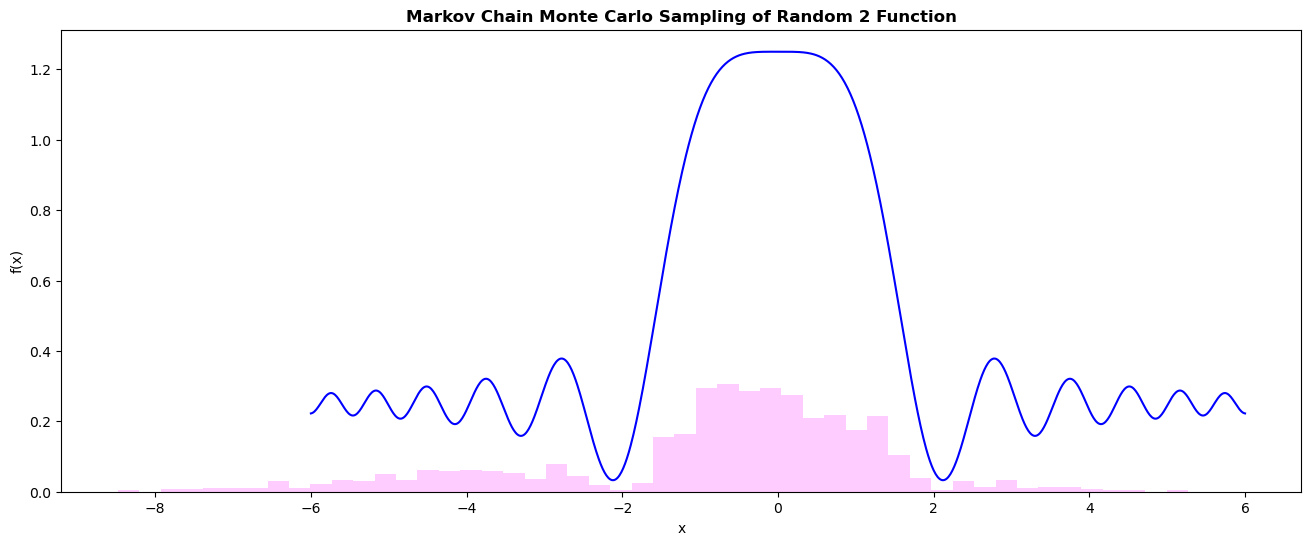

In [65]:
plot_MCMC(x, smth, 'Random 2', mhsmth)

[GO UP](#op0)